# barotropic streamfunction

Chris Bull (28/6/24) 

edited by Claire Yung

This notebook plots the barotropic streamfunction for each model as the time mean of the last available year for Ocean1 and Ocean2 COM runs.

Heavily hacked from OverturningStreamfunction.ipynb (thanks Adele!)

See https://github.com/misomip/isomip-plus/issues/6#issuecomment-2167202395

In [2]:
#Load required packages
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import cftime
import cmocean as cm

from netCDF4 import Dataset
import os.path
import matplotlib.colors as colors

In [3]:
## folder where the isomip-plus github repo is located
baserepo = '/g/data/x77/cy8964/isomip-plus/'
## folder where you downloaded the zipped Google Drive data
basedrive = '/g/data/x77/cy8964/ISOMIP+Data-new/'

# load the data from the text files, which point to the right location of the file in the drive structure
Ocean0_COM = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean0-COM.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean1_COM = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean1-COM.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean2_COM = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean2-COM.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean0_TYP = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean0-TYP.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean1_TYP = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean1-TYP.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean2_TYP = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean2-TYP.txt', dtype = 'str', delimiter = ',',usecols = 0)

def get_labels(expt):
    '''
    Get labels of experiments
    Make some modifications to names
    '''
    labels = []
    for fileIndex in range(len(expt)):
        fileName = expt[fileIndex]
        baseName = os.path.basename(basedrive +fileName)
        modelName = ' '.join(baseName.split('_')[2:]).split('.')[0]
        if "COM" in fileName:
            #make edits to COM names
            if "MOM6" in fileName:
                if "SIGMA_ZSTAR" not in fileName:
                    modelName = modelName + '-LAYER'
            elif "ROMS" in fileName:
                modelName = "ROMS"
        elif "TYP" in fileName:
            # make edits to COM names
            if "MOM6" in fileName:
                modelName = modelName + '-LAYER'
            elif "CNRS" in fileName:
                if "TYPa" in fileName:
                    modelName = modelName + '-TYPa'
                elif "TYPb" in fileName:
                    modelName = modelName + '-TYPb'
            elif "tides" in fileName:
                modelName = "ROMS-tides"
            elif "ROMS" in fileName:
                modelName = "ROMS"
        labels.append(modelName.strip('V3').replace(" ", "-"))
    return labels


In [4]:
linewidths = np.ones(21)*0.4
linewidths[10]=1.0

linestyles = ['--','--','--','--','--','--','--','--','--','--',
              'dotted',
              '-','-','-','-','-','-','-','-','-','-',]

In [5]:
def pbsf(expt,suptitle,tsteps,customlim=1,xlimmin = 440, figsize = (20,6)):
    labels = get_labels(expt)
    length = len(expt)
    alphabet = ['a','b','c','d','e','f','g','h','i','j','k','l','m']
    nrows = int(np.ceil(length/3))
    fig = plt.figure(figsize=figsize,facecolor='w',dpi = 150)
    time = tsteps
    for i in np.arange(length):
        ax = plt.subplot(3,nrows,i+1)
        data = xr.open_dataset(basedrive+expt[i], decode_times=False)
        #print(data.nTime)
        mr = data.barotropicStreamfunction.isel(nTime = np.arange(time-13,time)).mean('nTime')
        # last year of time
        #mr['nz'] = mr.nz*5+2.5 # add depth (2.5,7.5 etc)
        mr['ny'] = mr.ny*2+1
        mr['nx'] = mr.nx*2+321
        # mr<1e36 is to get rid of NaNs.
        c = (mr.where(mr <1e36).where(mr !=0)/1e6).plot.contourf(cmap = cm.cm.curl, levels = np.linspace(-customlim,customlim,41),extend = 'both',add_colorbar = False)#, cbar_kwargs = {'label':'Overturning \n Streamfunction (Sv)'},extend = 'both')
        ls = (mr.where(mr <1e36).where(mr !=0)/1e6).plot.contour( levels = np.linspace(-customlim,customlim,21), colors = 'k', 
                                                   linestyles = linestyles, linewidths = 0.7)
        mr2 = mr
        #mr2['ny'] = mr2.ny*2+1
        #mr2['nx'] = mr2.nx*2+321
        mr2 = (mr2.where(mr2<1e36).where(mr !=0)*0+1).fillna(0).sel(nx = slice(0,640)).plot.contour(levels = [0.5], colors = 'k',alpha = 0.5)
        xlim = [xlimmin, 660.]
        plt.xlim(xlim)
        plt.ylim(0,80)
        c.axes.set_aspect('equal')
        plt.text(0.01,0.99,alphabet[i], fontsize = 18, transform=ax.transAxes, fontweight='bold', va='top')
        plt.text(0.01,0.975,'    '+labels[i], fontsize = 15, transform=ax.transAxes, va='top')
        plt.yticks([0,40,80])
        if (i<nrows*2):
            ax.set_xticklabels([])
        if (i==0) or (i==nrows) or (i==nrows*2):
            plt.ylabel('y (km)', fontsize = 16)
        else:
            ax.set_yticklabels([])
            plt.ylabel('')
        if i>=nrows*2:
            plt.xlabel('x (km)', fontsize = 16)
        else:
            plt.xlabel('')
        plt.tick_params(labelsize=16)
        plt.vlines(640,0,80,color = 'k', linestyle = '--',linewidth =0.7)


    cax = plt.axes([0.93,0.1,0.01,0.8])
    cbar = plt.colorbar(c, cax = cax)
    cbar.add_lines(ls)
    cbar.lines[-1].set_linestyles(ls.linestyles)
    cbar.ax.set_ylabel('Barotropic Streamfunction (Sv)', fontsize = 16)
    cbar.ax.set_yticks(np.arange(-customlim,customlim+0.0001,customlim/5))
    plt.tick_params(labelsize=16)
    #cbar.add_lines(ls)
    fig.subplots_adjust(wspace = 0.05, hspace = 0.05)

    fig.suptitle(suptitle, fontsize = 20,y = 0.92);

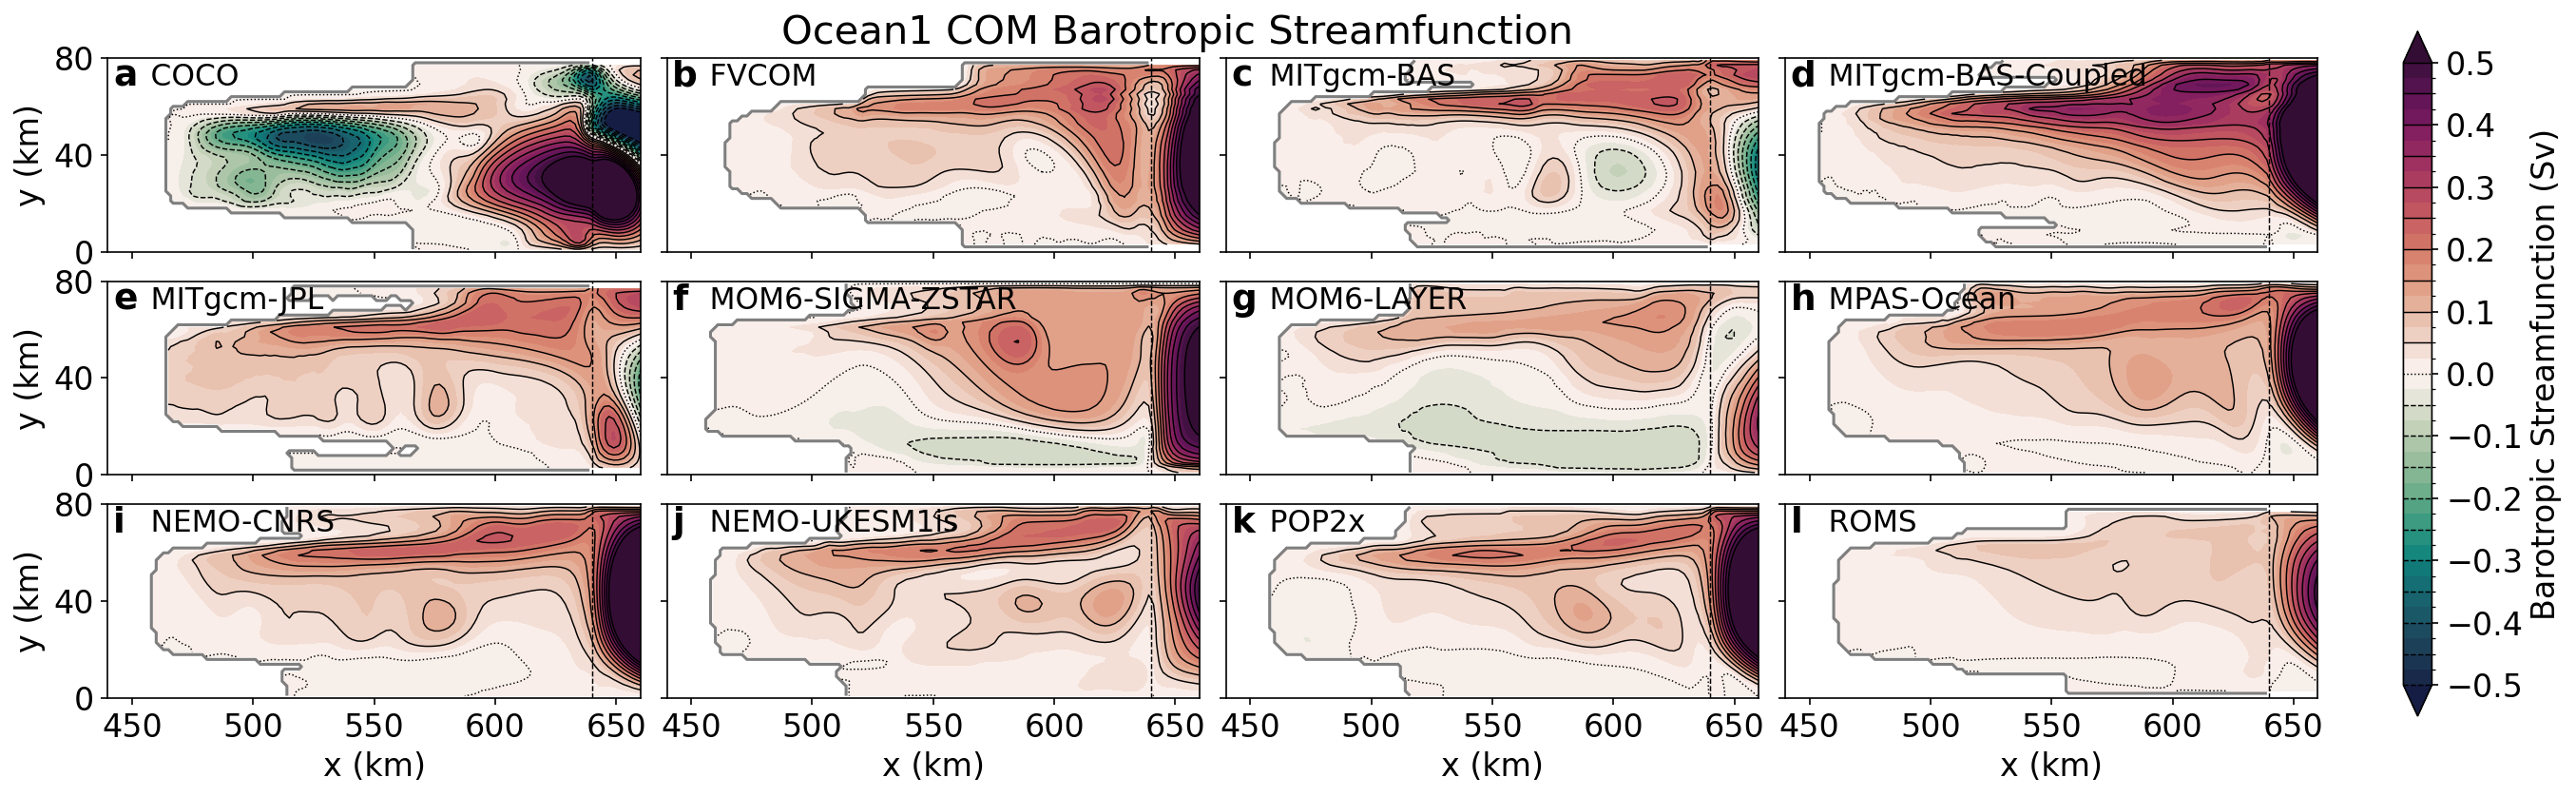

In [6]:
expt = Ocean1_COM
pbsf(expt,'Ocean1 COM Barotropic Streamfunction',240,0.5)

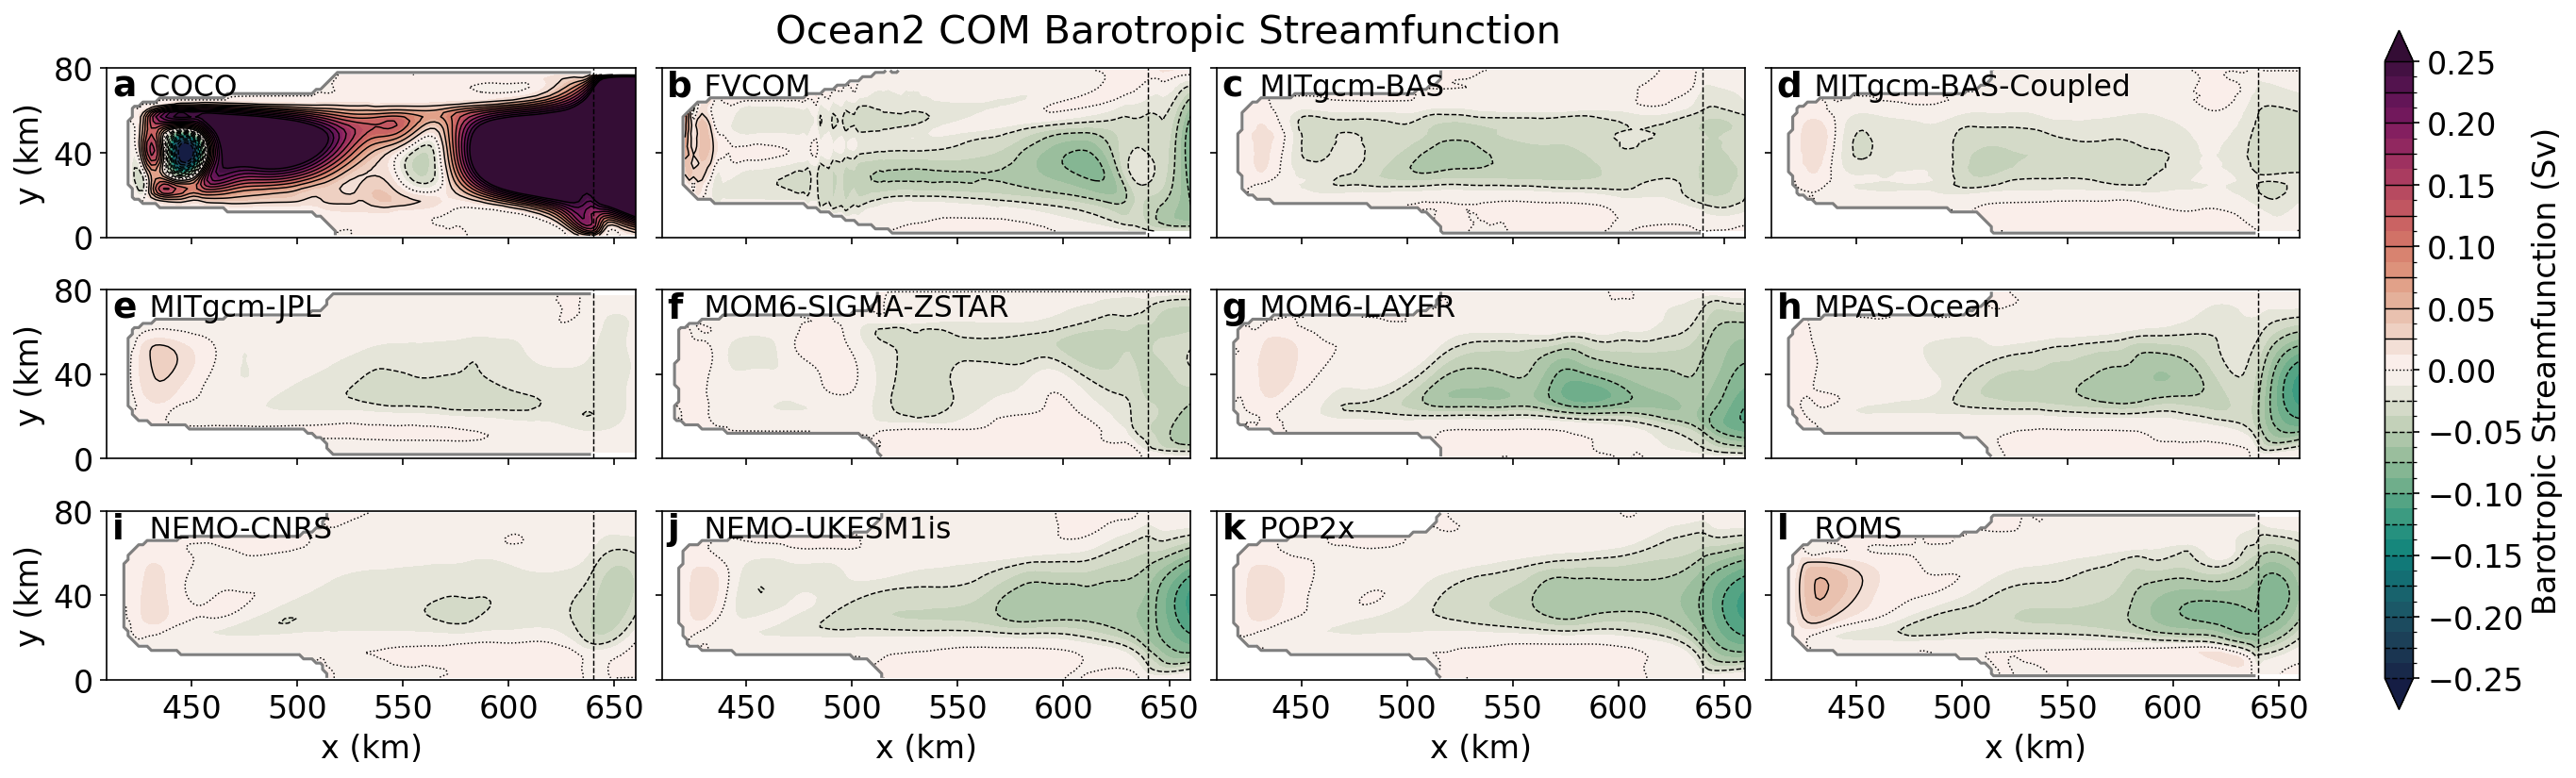

In [7]:
expt = Ocean2_COM
pbsf(expt,'Ocean2 COM Barotropic Streamfunction',240,0.25, xlimmin = 410)

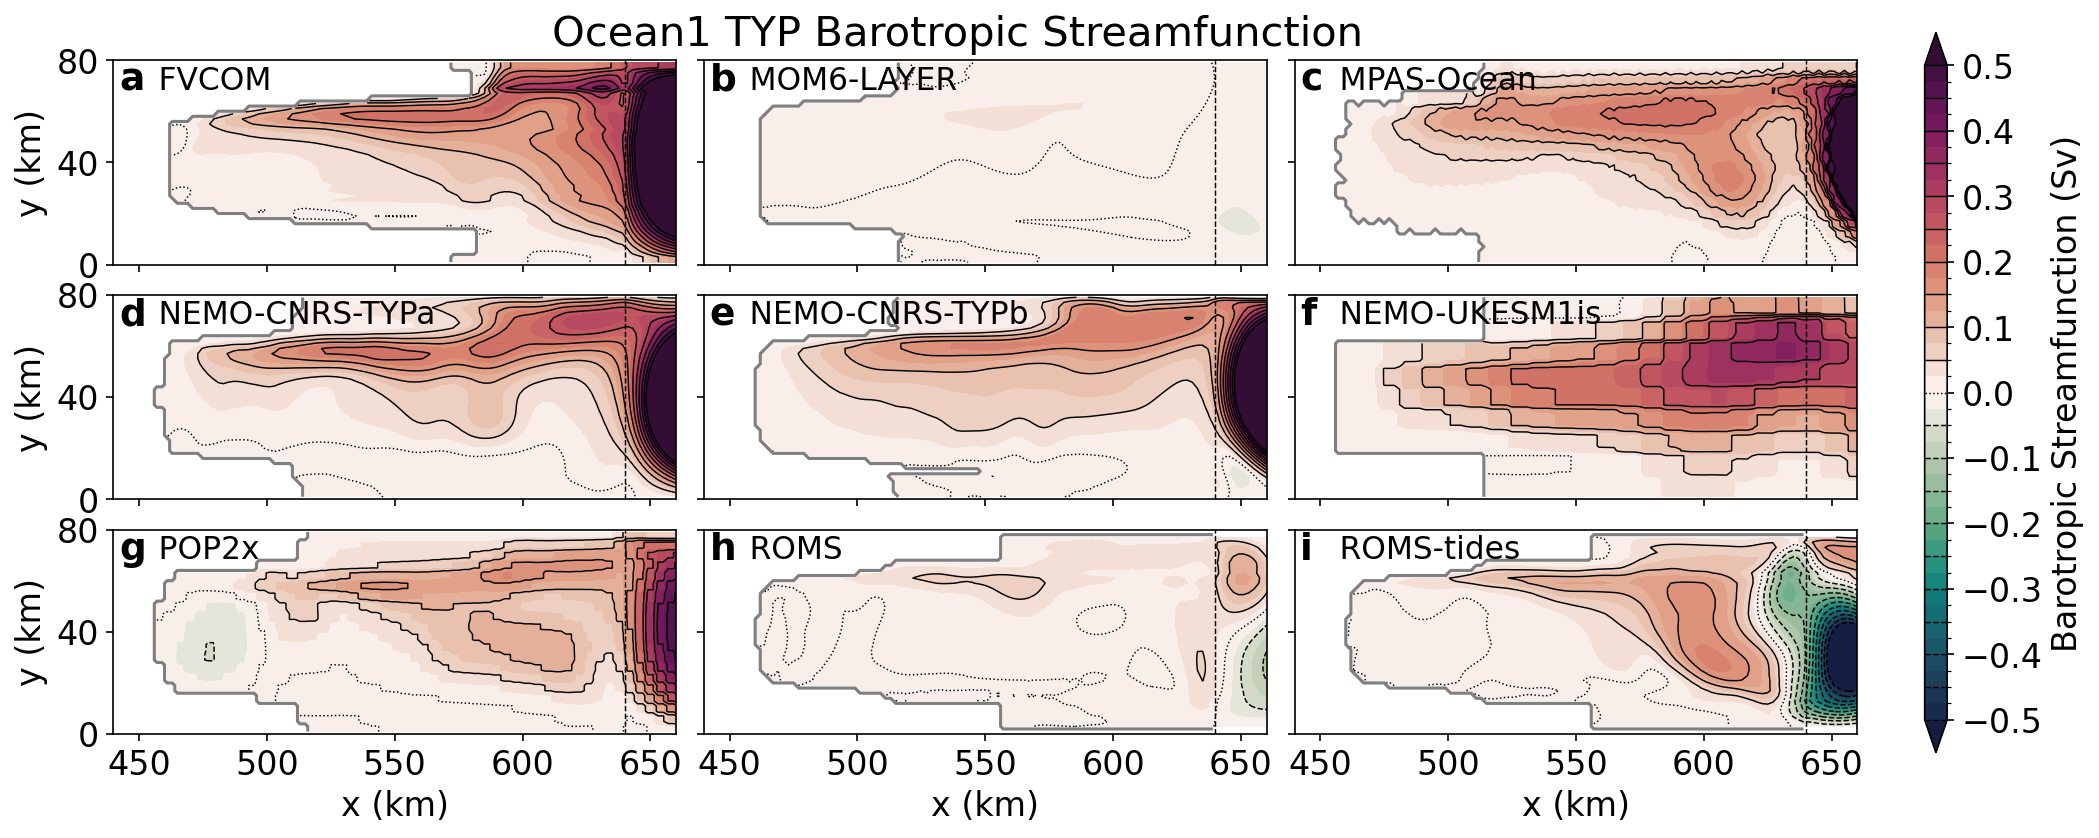

In [8]:
expt = Ocean1_TYP
pbsf(expt,'Ocean1 TYP Barotropic Streamfunction',240,0.5,figsize = (15,6))

In [9]:
def pbsf_full(expt,suptitle,tsteps,customlim=1, xlimmin = 440, figsize = (20,4.5)):
    labels = get_labels(expt)
    length = len(expt)
    alphabet = ['a','b','c','d','e','f','g','h','i','j','k','l','m']
    nrows = int(np.ceil(length/3))
    fig = plt.figure(figsize=figsize,facecolor='w',dpi = 150)
    time = tsteps
    for i in np.arange(length):
        ax = plt.subplot(3,nrows,i+1)
        data = xr.open_dataset(basedrive+expt[i], decode_times=False)
        #print(data.nTime)
        mr = data.barotropicStreamfunction.isel(nTime = np.arange(time-13,time)).mean('nTime')
        # last year of time
        #mr['nz'] = mr.nz*5+2.5 # add depth (2.5,7.5 etc)
        mr['ny'] = mr.ny*2
        mr['nx'] = mr.nx*2+321
        # mr<1e36 is to get rid of NaNs.
        c = (mr.where(mr <1e36).where(mr !=0)/1e6).plot.contourf(cmap = cm.cm.curl, levels = np.linspace(-customlim,customlim,41),extend = 'both',add_colorbar = False)#, cbar_kwargs = {'label':'Overturning \n Streamfunction (Sv)'},extend = 'both')
        ls = (mr.where(mr <1e36).where(mr !=0)/1e6).plot.contour( levels = np.linspace(-customlim,customlim,21), colors = 'k', 
                                                   linestyles = linestyles, linewidths = 0.7)
        mr2 = mr
        mr2 = (mr2.where(mr2<1e36).where(mr !=0)*0+1).fillna(0).sel(nx = slice(0,640)).plot.contour(levels = [0.5], colors = 'k',alpha = 0.5)

        xlim = [xlimmin, 800.]
        plt.xlim(xlim)
        plt.ylim(0,80)
        c.axes.set_aspect('equal')
#        plt.title('('+alphabet[i]+') '+labels[i], fontsize = 16)
        plt.text(0.01,1.01,alphabet[i], fontsize = 18, transform=ax.transAxes, fontweight='bold', va='bottom')
        plt.text(0.01,1.01,'    '+labels[i], fontsize = 15, transform=ax.transAxes, va='bottom')
        plt.yticks([0,40,80])
        if (i<nrows*2):
            ax.set_xticklabels([])
        if (i==0) or (i==nrows) or (i==nrows*2):
            plt.ylabel('y (km)', fontsize = 16)
        else:
            ax.set_yticklabels([])
            plt.ylabel('')
        if i>=nrows*2:
            plt.xlabel('x (km)', fontsize = 16)
        else:
            plt.xlabel('')
        plt.tick_params(labelsize=16)
        plt.vlines(640,0,80,color = 'k', linestyle = '--',linewidth =0.7)


    cax = plt.axes([0.93,0.1,0.01,0.8])
    cbar = plt.colorbar(c, cax = cax)
    cbar.ax.set_ylabel('Barotropic Streamfunction (Sv)', fontsize = 16)
    cbar.add_lines(ls)
    cbar.lines[-1].set_linestyles(ls.linestyles)
    cbar.ax.set_yticks(np.arange(-customlim,customlim+0.0001,customlim/5))
    plt.tick_params(labelsize=16)
    fig.subplots_adjust(wspace = 0.05, hspace = 0.05)

    fig.suptitle(suptitle, fontsize = 20)#, y = 0.92);

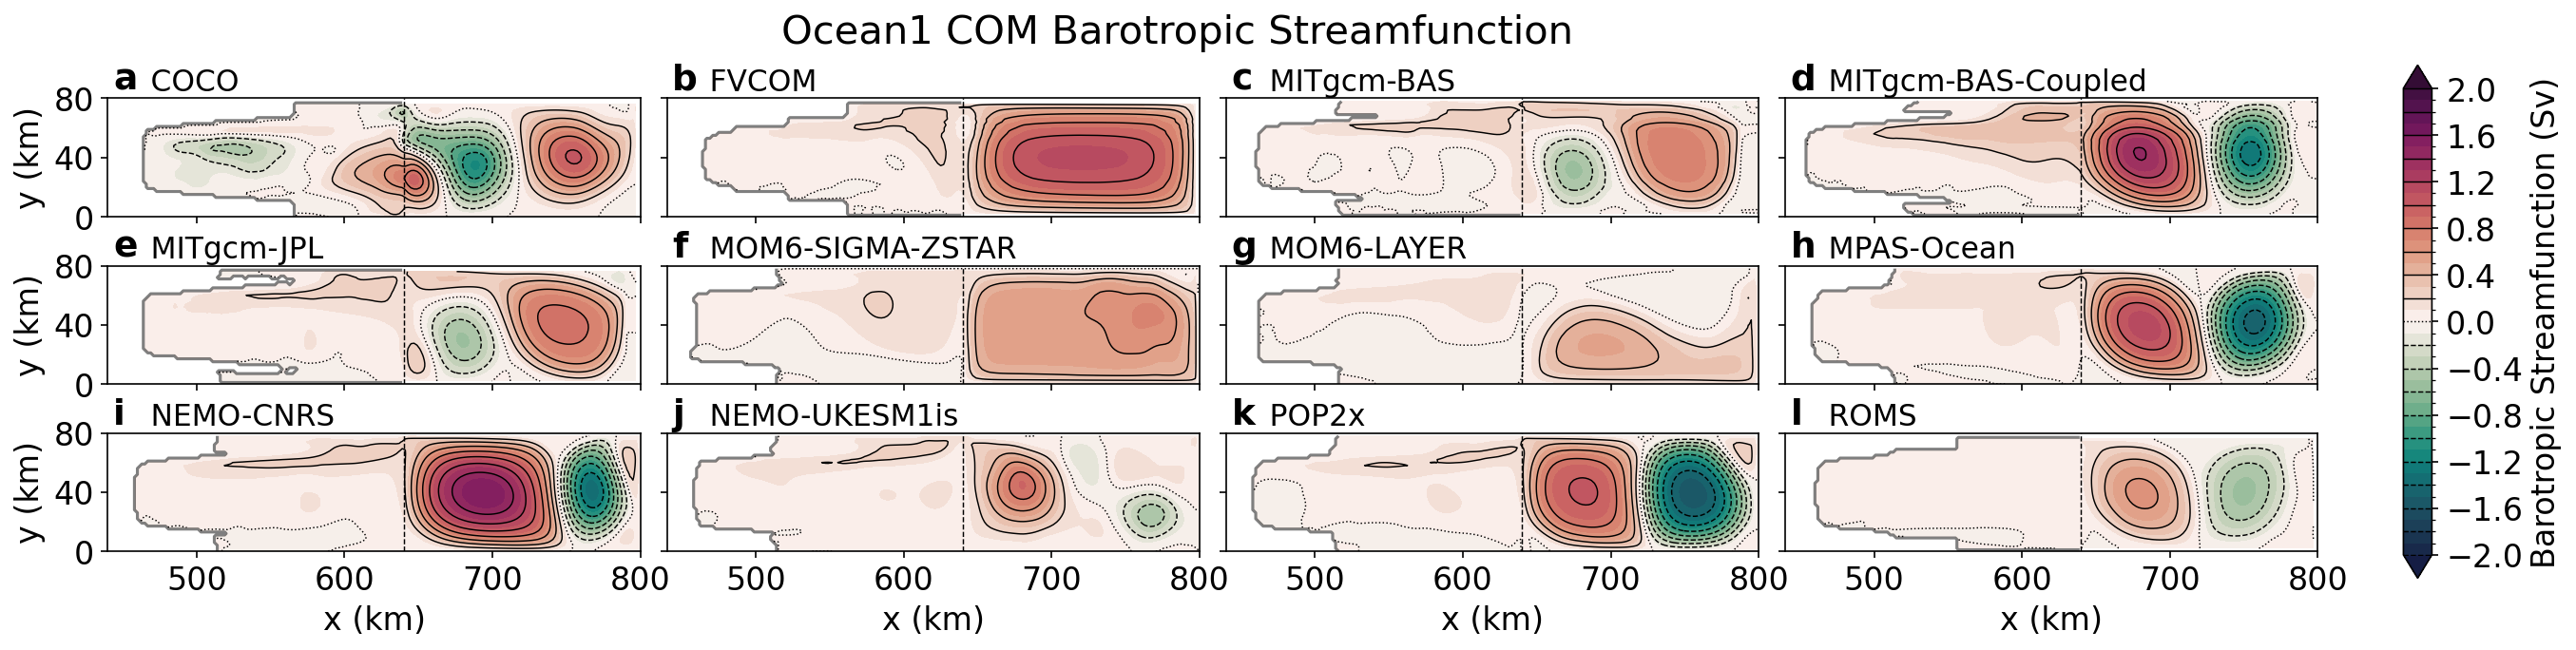

In [10]:
expt = Ocean1_COM
pbsf_full(expt,'Ocean1 COM Barotropic Streamfunction',240,2)

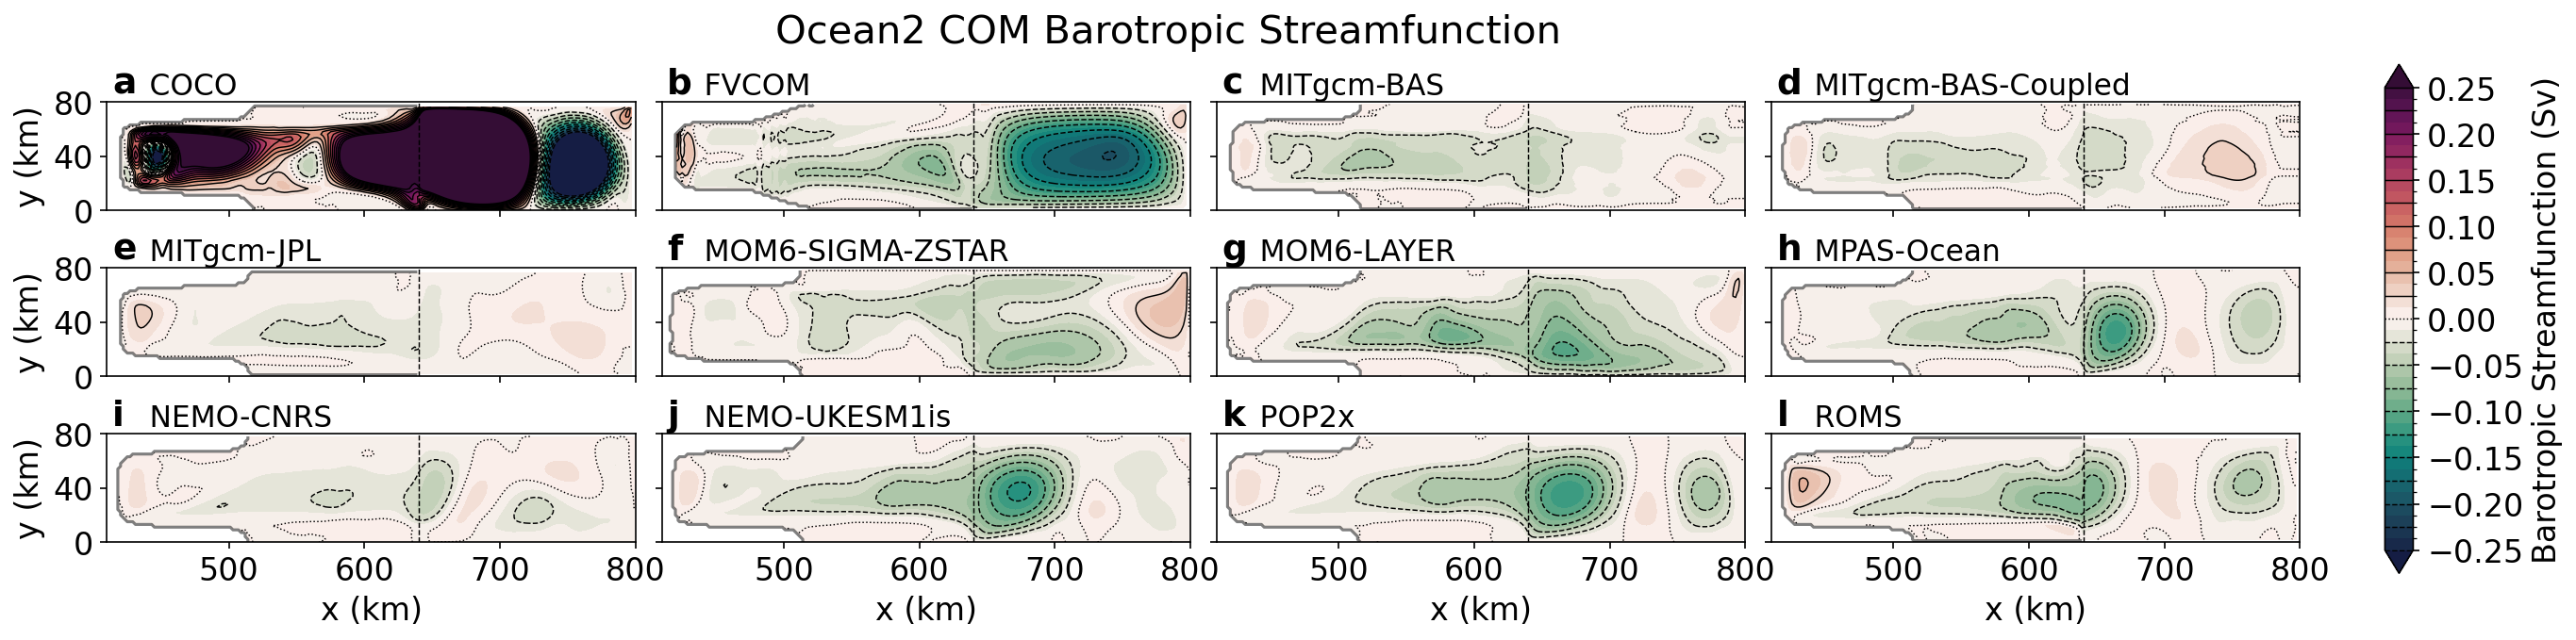

In [11]:
expt = Ocean2_COM
pbsf_full(expt,'Ocean2 COM Barotropic Streamfunction',240,0.25,xlimmin = 410)